<a href="https://colab.research.google.com/github/JFrankVC/time_series/blob/main/TimeSeries_Forecasting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima_process import ArmaProcess
from statsmodels.tsa.stattools import adfuller
from tqdm import tqdm_notebook
from itertools import product

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

In [ ]:
plt.style.available

['Solarize_Light2',
 '_classic_test_patch',
 '_mpl-gallery',
 '_mpl-gallery-nogrid',
 'bmh',
 'classic',
 'dark_background',
 'fast',
 'fivethirtyeight',
 'ggplot',
 'grayscale',
 'seaborn-v0_8',
 'seaborn-v0_8-bright',
 'seaborn-v0_8-colorblind',
 'seaborn-v0_8-dark',
 'seaborn-v0_8-dark-palette',
 'seaborn-v0_8-darkgrid',
 'seaborn-v0_8-deep',
 'seaborn-v0_8-muted',
 'seaborn-v0_8-notebook',
 'seaborn-v0_8-paper',
 'seaborn-v0_8-pastel',
 'seaborn-v0_8-poster',
 'seaborn-v0_8-talk',
 'seaborn-v0_8-ticks',
 'seaborn-v0_8-white',
 'seaborn-v0_8-whitegrid',
 'tableau-colorblind10']

In [ ]:
plt.style.use('dark_background')

## 2. Naive Prediction of the Future

In [ ]:
ds = pd.read_csv('https://raw.githubusercontent.com/marcopeix/TimeSeriesForecastingInPython/master/data/jj.csv')
ds.head()

,date,data
0,1960-01-01,0.71
1,1960-04-01,0.63
2,1960-07-02,0.85
3,1960-10-01,0.44
4,1961-01-01,0.61


In [ ]:
ds.tail()

,date,data
79,1979-10-01,9.99
80,1980-01-01,16.20
81,1980-04-01,14.67
82,1980-07-02,16.02
83,1980-10-01,11.61


In [ ]:
train = ds[:-4]
test = ds[-4:]

In [ ]:
time = pd.DatetimeIndex(ds['date']).year
time_s = pd.Series(ds['date'])

In [ ]:
time_s

0     1960-01-01
1     1960-04-01
2     1960-07-02
3     1960-10-01
4     1961-01-01
         ...    
79    1979-10-01
80    1980-01-01
81    1980-04-01
82    1980-07-02
83    1980-10-01
Name: date, Length: 84, dtype: object

In [ ]:
import matplotlib.ticker as ticker

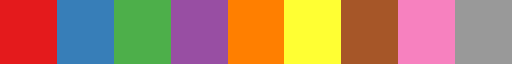

<Figure size 640x480 with 0 Axes>

In [ ]:
cmap = plt.set_cmap('Set1')
cmap = plt.get_cmap()
cmap

In [ ]:
cmap = cmap.colors
cmap

((0.8941176470588236, 0.10196078431372549, 0.10980392156862745),
 (0.21568627450980393, 0.49411764705882355, 0.7215686274509804),
 (0.30196078431372547, 0.6862745098039216, 0.2901960784313726),
 (0.596078431372549, 0.3058823529411765, 0.6392156862745098),
 (1.0, 0.4980392156862745, 0.0),
 (1.0, 1.0, 0.2),
 (0.6509803921568628, 0.33725490196078434, 0.1568627450980392),
 (0.9686274509803922, 0.5058823529411764, 0.7490196078431373),
 (0.6, 0.6, 0.6))

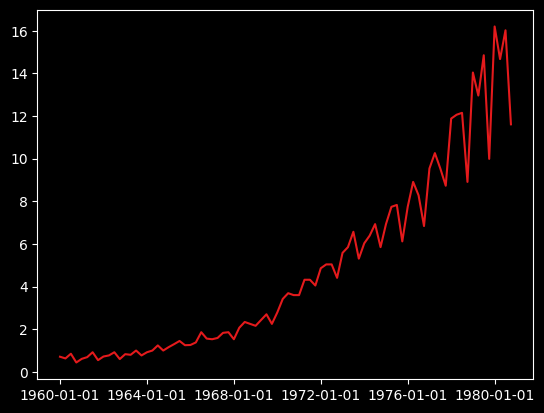

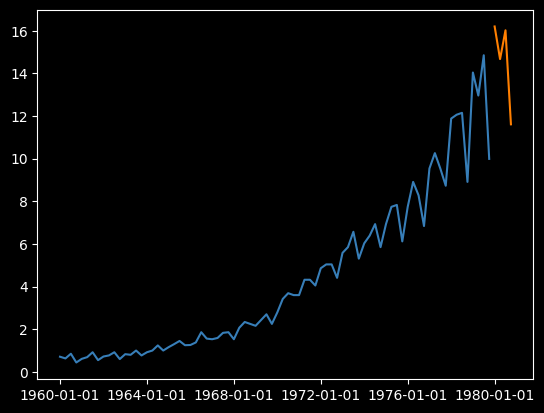

In [ ]:
fig, ax = plt.subplots(1, 1)
ax.plot(time_s, ds['data'], color=cmap[0])
space=16
ax.xaxis.set_major_locator(ticker.MultipleLocator(space))

fig, ax = plt.subplots(1, 1)
ax.plot(train['date'], train['data'], color=cmap[1])
ax.plot(test['date'], test['data'], color=cmap[4])
space=16
ax.xaxis.set_major_locator(ticker.MultipleLocator(space))

### Predicting based on historical data (train)

In [ ]:
# Mean from train ds as prediction for test points
historical_mean = train['data'].mean()
print(historical_mean)

test['pred_mean'] = historical_mean
test.head()

4.308499987499999


,date,data,pred_mean
80,1980-01-01,16.20,4.3085
81,1980-04-01,14.67,4.3085
82,1980-07-02,16.02,4.3085
83,1980-10-01,11.61,4.3085


In [ ]:
# MAPE metric (mean absolute percentage error)
def mape(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

mape_hist_mean = mape(test['data'], test['pred_mean'])
mape_hist_mean

70.00752579965119

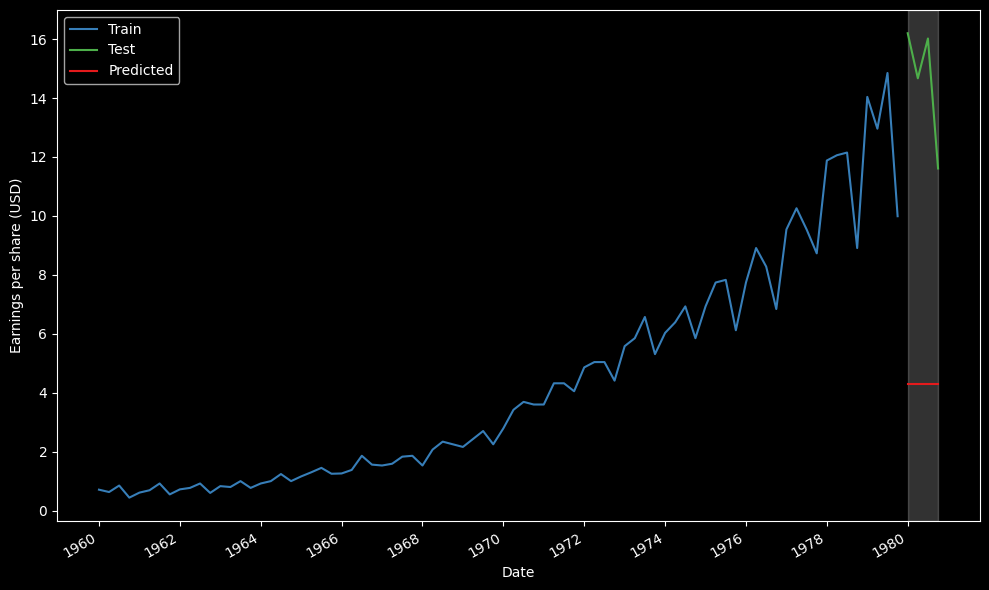

In [ ]:
fig, ax = plt.subplots(figsize=(10, 6))

ax.plot(train['date'], train['data'], c=cmap[1], label='Train')
ax.plot(test['date'], test['data'], c=cmap[2], label='Test')
ax.plot(test['date'], test['pred_mean'], c=cmap[0], label='Predicted')
ax.set_xlabel('Date')
ax.set_ylabel('Earnings per share (USD)')
ax.axvspan(80, 83, color='#ffffff', alpha=0.2)  # draws bar covering test and pred
ax.legend(loc=2)

plt.xticks(np.arange(0, 85, 8), [1960, 1962, 1964, 1966, 1968, 1970, 1972, 1974, 1976, 1978, 1980])

fig.autofmt_xdate()
plt.tight_layout()

### Predicting based on previous year (last quarters in train)

In [ ]:
# calculate mean based on previous year
last_year_mean = train['data'][-4:].mean()
print(last_year_mean)

12.96


In [ ]:
test['pred_last_year_mean'] = last_year_mean
test.head()

,date,data,pred_mean,pred_last_year_mean
80,1980-01-01,16.20,4.3085,12.96
81,1980-04-01,14.67,4.3085,12.96
82,1980-07-02,16.02,4.3085,12.96
83,1980-10-01,11.61,4.3085,12.96


In [ ]:
mape_last_year_mean = mape(test['data'], test['pred_last_year_mean'])
mape_last_year_mean

15.5963680725103

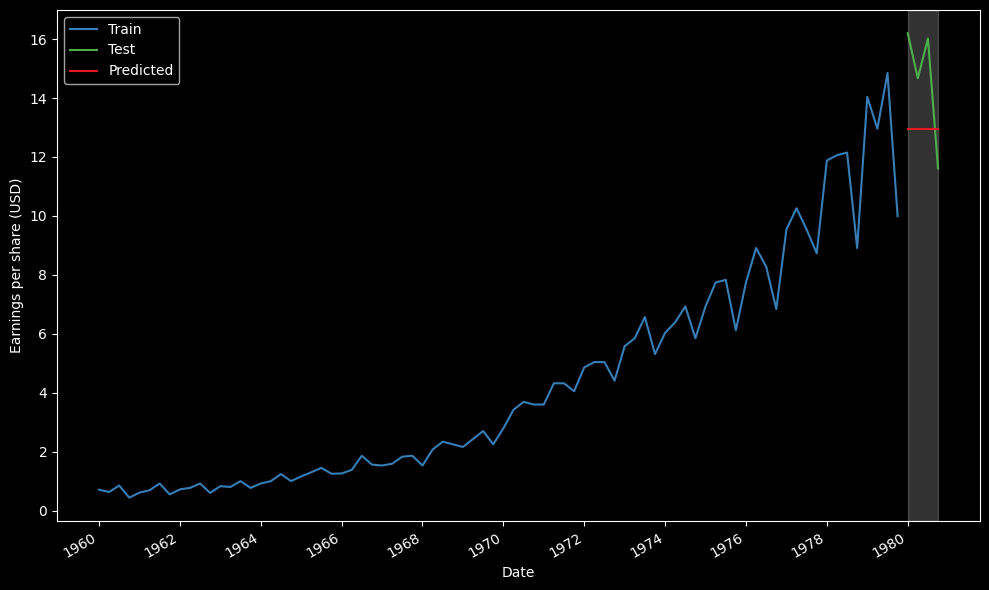

In [ ]:
fig, ax = plt.subplots(figsize=(10, 6))

ax.plot(train['date'], train['data'], c=cmap[1], label='Train')
ax.plot(test['date'], test['data'], c=cmap[2], label='Test')
ax.plot(test['date'], test['pred_last_year_mean'], c=cmap[0], label='Predicted')
ax.set_xlabel('Date')
ax.set_ylabel('Earnings per share (USD)')
ax.axvspan(80, 83, color='#ffffff', alpha=0.2)  # draws bar covering test and pred
ax.legend(loc=2)

plt.xticks(np.arange(0, 85, 8), [1960, 1962, 1964, 1966, 1968, 1970, 1972, 1974, 1976, 1978, 1980])

fig.autofmt_xdate()
plt.tight_layout()

### Predictin based on last quarter (last in train)

In [ ]:
last = train['data'].iloc[-1]
print(last)

9.99


In [ ]:
test['pred_last'] = last
test.head()

,date,data,pred_mean,pred_last_year_mean,pred_last
80,1980-01-01,16.20,4.3085,12.96,9.99
81,1980-04-01,14.67,4.3085,12.96,9.99
82,1980-07-02,16.02,4.3085,12.96,9.99
83,1980-10-01,11.61,4.3085,12.96,9.99


In [ ]:
mape_last = mape(test['data'], test['pred_last'])
mape_last

30.457277908606535

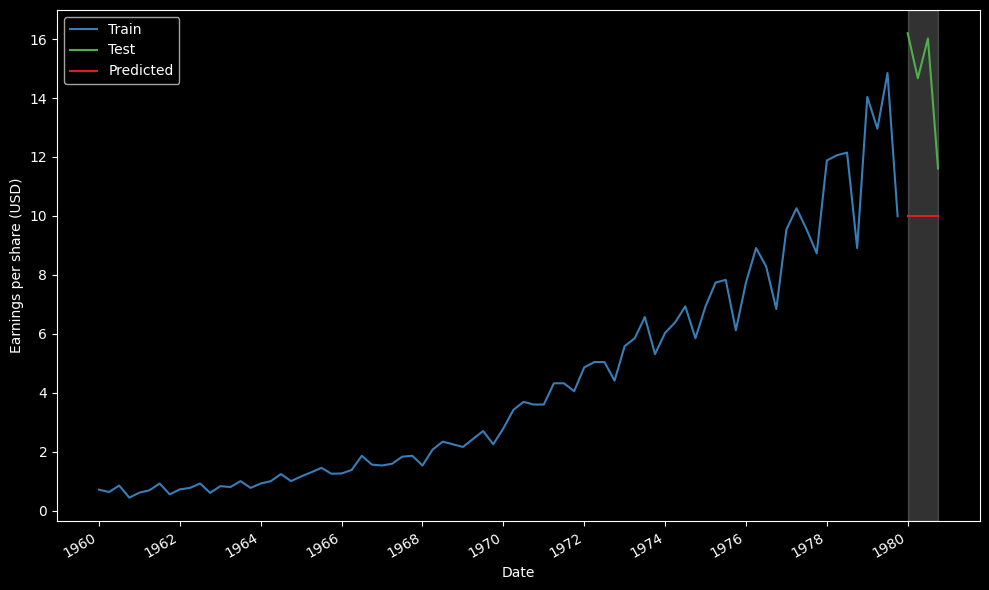

In [ ]:
fig, ax = plt.subplots(figsize=(10, 6))

ax.plot(train['date'], train['data'], c=cmap[1], label='Train')
ax.plot(test['date'], test['data'], c=cmap[2], label='Test')
ax.plot(test['date'], test['pred_last'], c=cmap[0], label='Predicted')
ax.set_xlabel('Date')
ax.set_ylabel('Earnings per share (USD)')
ax.axvspan(80, 83, color='#ffffff', alpha=0.2)  # draws bar covering test and pred
ax.legend(loc=2)

plt.xticks(np.arange(0, 85, 8), [1960, 1962, 1964, 1966, 1968, 1970, 1972, 1974, 1976, 1978, 1980])

fig.autofmt_xdate()
plt.tight_layout()

### Predicting by naive seasonal forecast

In [ ]:
test['pred_last_season'] = train['data'][-4:].values
test.head()

,date,data,pred_mean,pred_last_year_mean,pred_last,pred_last_season
80,1980-01-01,16.20,4.3085,12.96,9.99,14.04
81,1980-04-01,14.67,4.3085,12.96,9.99,12.96
82,1980-07-02,16.02,4.3085,12.96,9.99,14.85
83,1980-10-01,11.61,4.3085,12.96,9.99,9.99


In [ ]:
mape_naive_seasonal = mape(test['data'], test['pred_last_season'])
mape_naive_seasonal

11.561658552433654

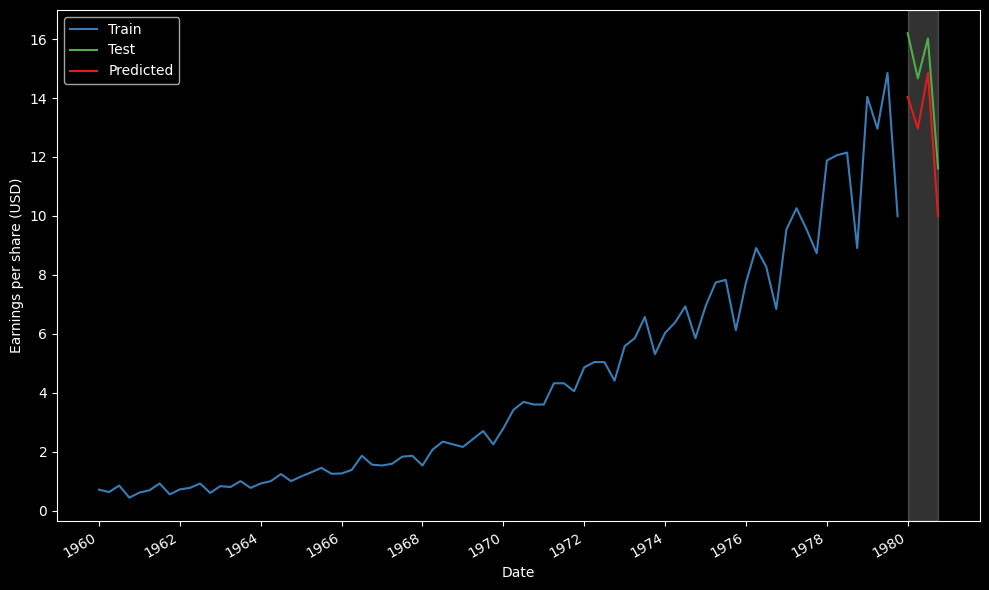

In [ ]:
fig, ax = plt.subplots(figsize=(10, 6))

ax.plot(train['date'], train['data'], c=cmap[1], label='Train')
ax.plot(test['date'], test['data'], c=cmap[2], label='Test')
ax.plot(test['date'], test['pred_last_season'], c=cmap[0], label='Predicted')
ax.set_xlabel('Date')
ax.set_ylabel('Earnings per share (USD)')
ax.axvspan(80, 83, color='#ffffff', alpha=0.2)  # draws bar covering test and pred
ax.legend(loc=2)

plt.xticks(np.arange(0, 85, 8), [1960, 1962, 1964, 1966, 1968, 1970, 1972, 1974, 1976, 1978, 1980])

fig.autofmt_xdate()
plt.tight_layout()

### Compare MAPE metrics

<BarContainer object of 4 artists>


Text(0.5, 1.0, 'MAPE Histogram')

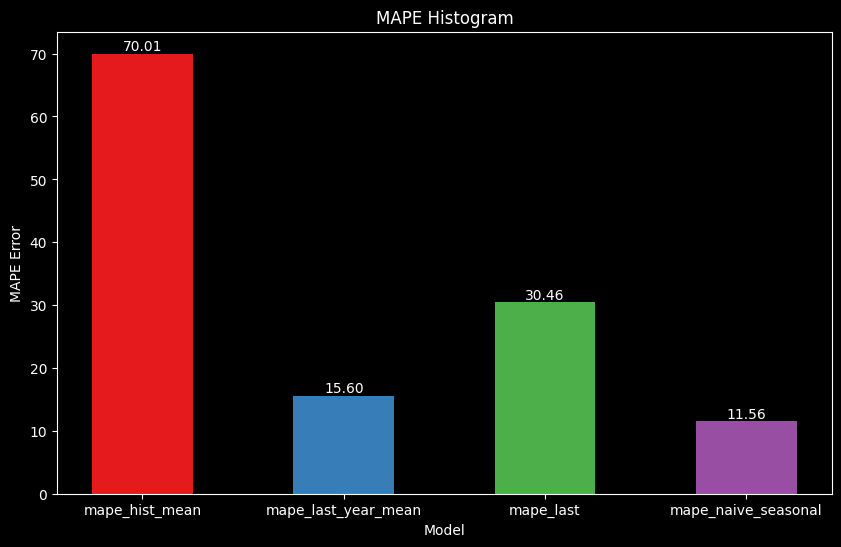

In [ ]:
fig, ax = plt.subplots(figsize=(10, 6))

ax.bar(
    x = np.array([0,1,2,3]),
    height=np.array([mape_hist_mean, mape_last_year_mean, mape_last, mape_naive_seasonal]),
    width=0.5,
    color=cmap,
    )

for bars in ax.containers:
    print(bars)
    ax.bar_label(bars, fmt='%.2f')

plt.xticks(np.arange(0, 4), ['mape_hist_mean', 'mape_last_year_mean', 'mape_last', 'mape_naive_seasonal'])

plt.xlabel('Model')
plt.ylabel('MAPE Error')
plt.title('MAPE Histogram')

## 3. A Random Walk

A random walk is a process in which there is an equal chance of going up or down by a random number.

Random walks often expose long periods where a positive or negative trend can be observed. They are also often accompanied by sudden changes in direction.

In a *random walk process*, we say that the present value $y_t$ is a function of the value at the previous timestep $y_{t–1}$, a constant $C$, and a random number $ϵ_t$, also termed *white noise*. Here, $ϵ_t$ is the realization of the *standard normal distribution*, which has a variance of 1 and a mean of 0.

$$y_t = C + y_{t–1} + ϵ_t$$

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

plt.style.use('dark_background')

In [ ]:
np.random.seed(42)
steps = np.random.standard_normal(1000)
steps[0] = 0

random_walk = np.cumsum(steps)

Text(0.5, 1.0, 'Random Walk')

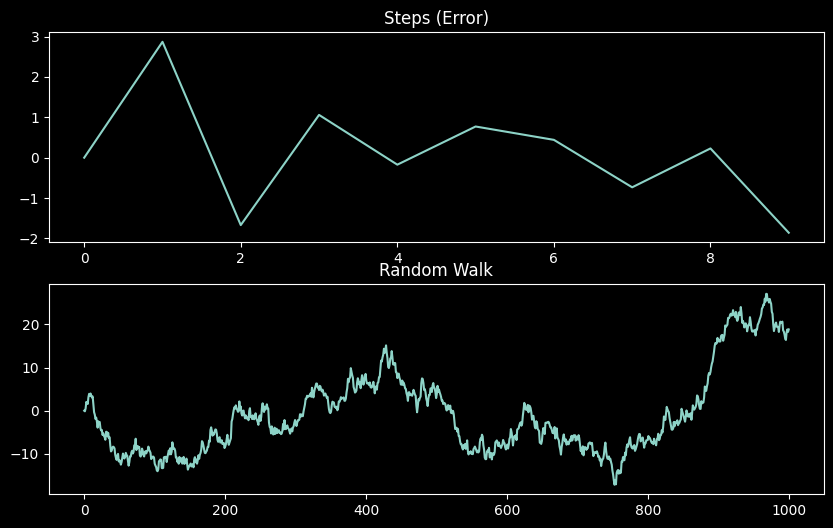

In [ ]:
fig, ax = plt.subplots(2, 1, figsize=(10, 6))

ax[0].plot(steps)
ax[0].set_title('Steps (Error)')

ax[1].plot(random_walk)
ax[1].set_title('Random Walk')

Text(0.5, 1.0, 'Random Walk')

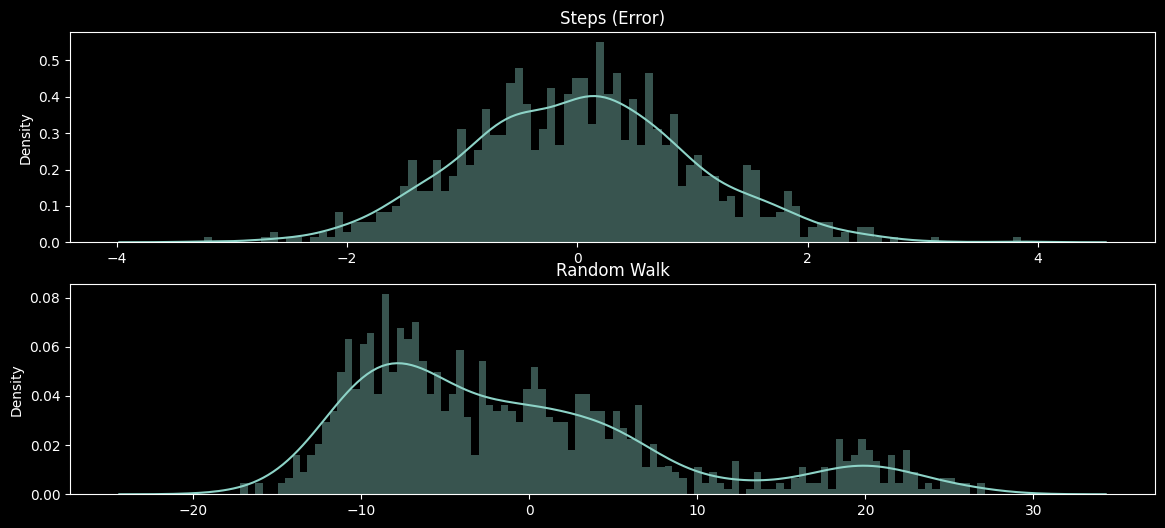

In [ ]:
fig, ax = plt.subplots(2, 1, figsize=(14, 6))

sns.distplot(steps, ax=ax[0], bins=int(len(steps)*0.1))
ax[0].set_title('Steps (Error)')

sns.distplot(random_walk, ax=ax[1], bins=int(len(random_walk)*0.1))
ax[1].set_title('Random Walk')

In [ ]:
steps = np.random.standard_normal(1000)
steps[0] = 0

y_unit = np.cumsum(steps)

y_0_5 = [0]
for i in range(1, len(steps)):
    y_0_5.append(0.5*y_0_5[i-1] + steps[i])

In [ ]:
y_0_5

[0,
 2.8684030556667683,
 -0.2343977310448111,
 0.9415296643614733,
 0.2979630947842723,
 0.9209017022288113,
 0.9017580028136515,
 -0.28227719570317084,
 0.08785779460775484,
 -1.8139725540944098]

Text(0.5, 1.0, 'Y - 0.5 circle')

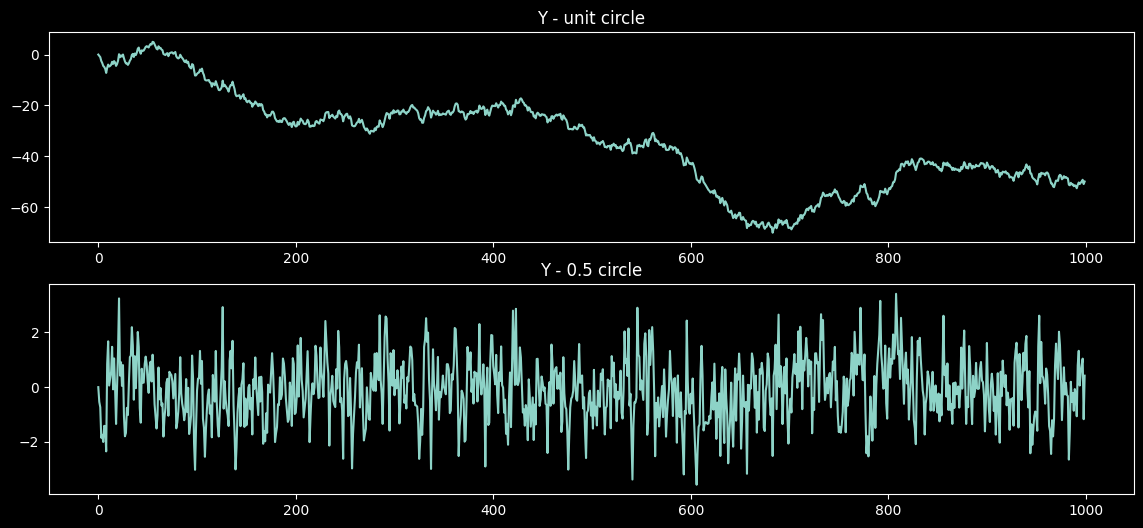

In [ ]:
fig, ax = plt.subplots(2, 1, figsize=(14, 6))

sns.lineplot(y_unit, ax=ax[0])
ax[0].set_title('Y - unit circle')

sns.lineplot(y_0_5, ax=ax[1])
ax[1].set_title('Y - 0.5 circle')

In [ ]:
steps

array([ 0.        , -0.86038501, -0.41360553,  1.88768766,  0.55655312,
       -1.33548157,  0.48603629, -1.54730399,  1.08269105, -0.47112465])

In [ ]:
RED = '\033[91m'
GREEN = '\033[92m'
BLUE = '\033[94m'
WHITE = '\033[97m'
YELLOW = '\033[93m'

The augmented Dickey-Fuller (`ADF`) test helps us determine if a time series is stationary by testing for the presence of a unit root. If a unit root is present, the time series is not stationary.

The null hypothesis states that a unit root is present, meaning that our time series is not stationary.

In [ ]:
from statsmodels.tsa.stattools import adfuller

ADF_result = adfuller(random_walk)

print(f'{WHITE}RANDOM WALK - ADF Statistic: {ADF_result[0]} - {RED}Not very large negative number, cannot reject null hypothesis')
print(f'{WHITE}RANDOM WALK - p-value: {ADF_result[1]} - {RED}Greater than 0.05, cannot reject null hypothesis')

RANDOM WALK - ADF Statistic: -0.965952487691875 - Not very large negative number, cannot reject null hypothesis
RANDOM WALK - p-value: 0.7654789696692581 - Greater than 0.05, cannot reject null hypothesis


In [ ]:
ADF_result = adfuller(y_unit)

print(f'{WHITE}ADF Statistic: {ADF_result[0]} - {RED}Not very large negative number, cannot reject null hypothesis')
print(f'{WHITE}p-value: {ADF_result[1]} - {RED}Greater than 0.05, cannot reject null hypothesis')

ADF Statistic: -1.6184150785811617 - Not very large negative number, cannot reject null hypothesis
p-value: 0.4735603088648087 - Greater than 0.05, cannot reject null hypothesis


In [ ]:
ADF_result = adfuller(y_0_5)

print(f'{WHITE}ADF Statistic: {ADF_result[0]} - {GREEN}Very large negative number, can reject null hypothesis')
print(f'{WHITE}p-value: {ADF_result[1]} - {GREEN}Lower than 0.05, can reject null hypothesis')

ADF Statistic: -19.288384582541827 - Very large negative number, can reject null hypothesis
p-value: 0.0 - Lower than 0.05, can reject null hypothesis


The autocorrelation function (`ACF`) measures the linear relationship between lagged values of a time series.

**What is ACF plot ?**
A *time series* is a sequence of measurements of the same variable(s) made over time. Usually, the measurements are made at evenly spaced times — for example, monthly or yearly. The coefficient of correlation between two values in a time series is called the autocorrelation function (ACF). In other words,

*   Autocorrelation represents the degree of similarity between a given time series and a lagged version of itself over successive time intervals.
*   Autocorrelation measures the relationship between a variable’s current value and its past values.
*   An autocorrelation of +1 represents a perfect positive correlation, while an autocorrelation of negative 1 represents a perfect negative correlation.

Text(0.5, 1.0, 'Y - unit circle')

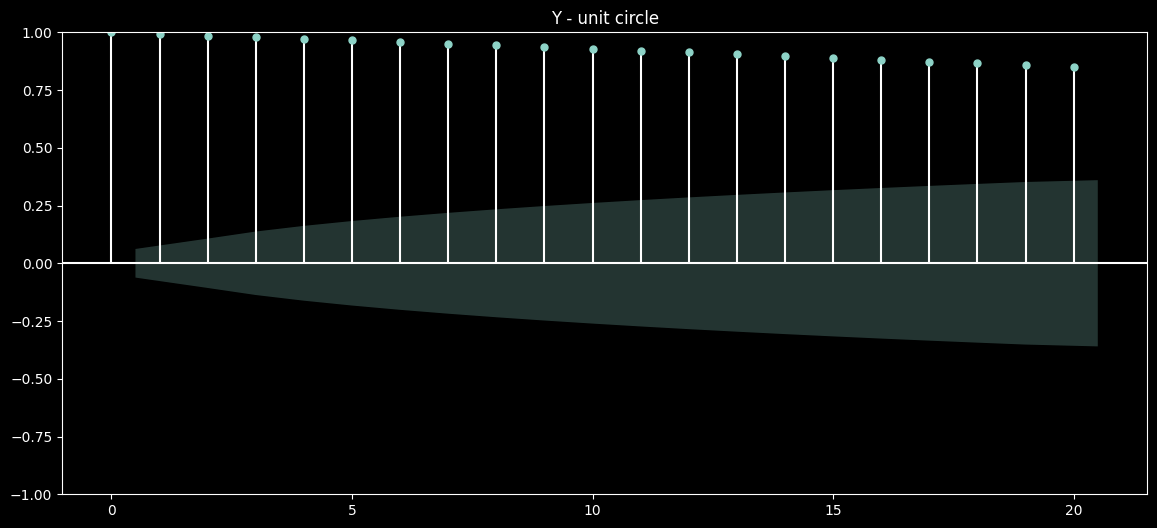

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf

fig, ax = plt.subplots(1, 1, figsize=(14, 6))

plot_acf(random_walk, lags=20, ax=ax)
ax.set_title('Y - unit circle')


Text(0.5, 1.0, 'Y - 0.5 circle')

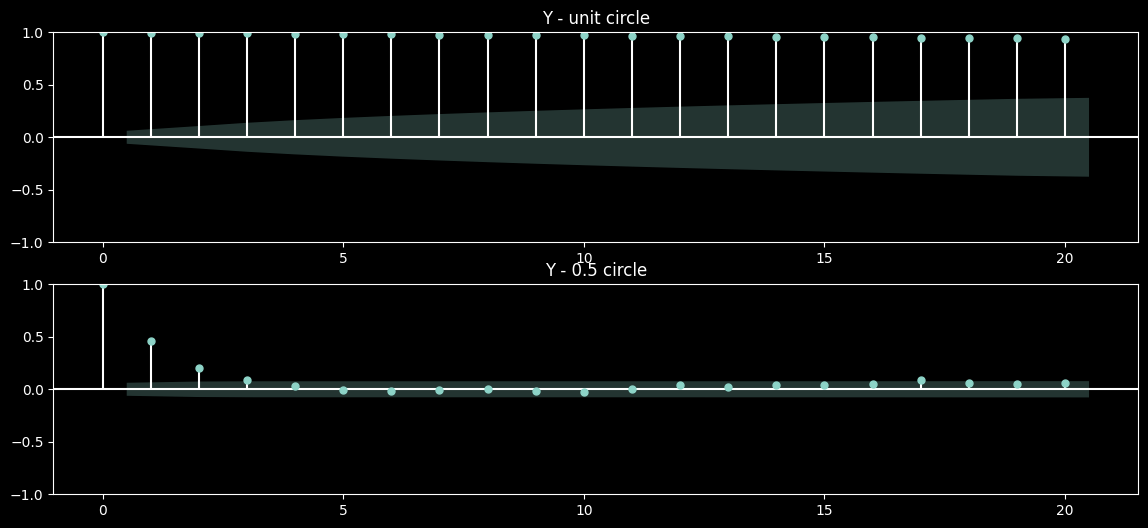

In [ ]:
fig, ax = plt.subplots(2, 1, figsize=(14, 6))

plot_acf(y_unit, lags=20, ax=ax[0])
ax[0].set_title('Y - unit circle')

plot_acf(y_0_5, lags=20, ax=ax[1])
ax[1].set_title('Y - 0.5 circle')

Because our random walk is not stationary, we need to apply a transformation to make it stationary in order to retrieve useful information from the ACF plot. Since our sequence mostly displays changes in the trend without seasonal patterns, we will apply a **first-order differencing**. Remember that we’ll lose the first data point every time we difference.

In [ ]:
diff_random_walk = np.diff(random_walk, n=1)

Text(0.5, 1.0, 'Diff Random Walk')

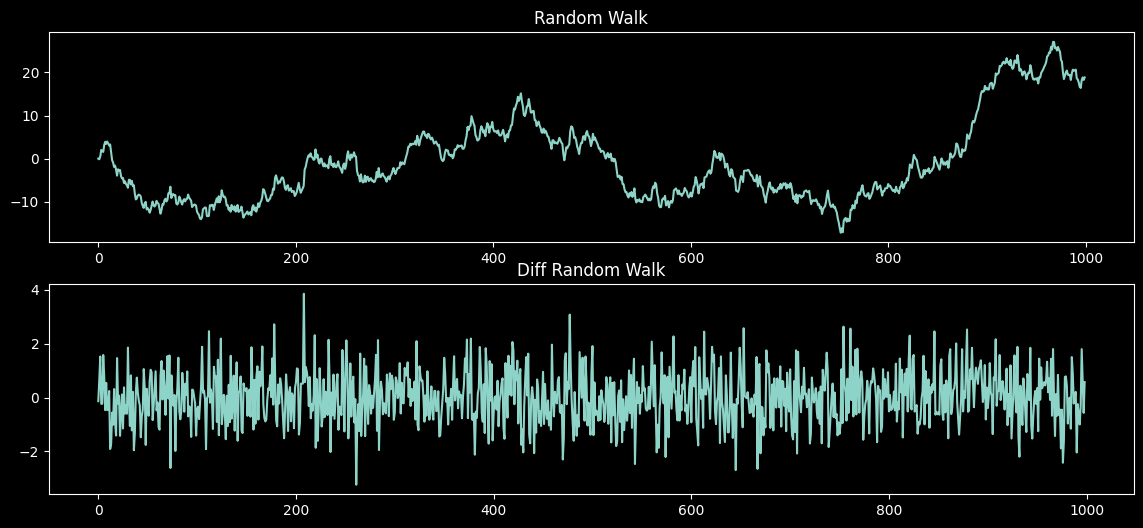

In [ ]:
fig, ax = plt.subplots(2, 1, figsize=(14, 6))

sns.lineplot(random_walk, ax=ax[0])
ax[0].set_title('Random Walk')

sns.lineplot(diff_random_walk, ax=ax[1])
ax[1].set_title('Diff Random Walk')

Text(0.5, 1.0, 'ACF Diff Random Walk')

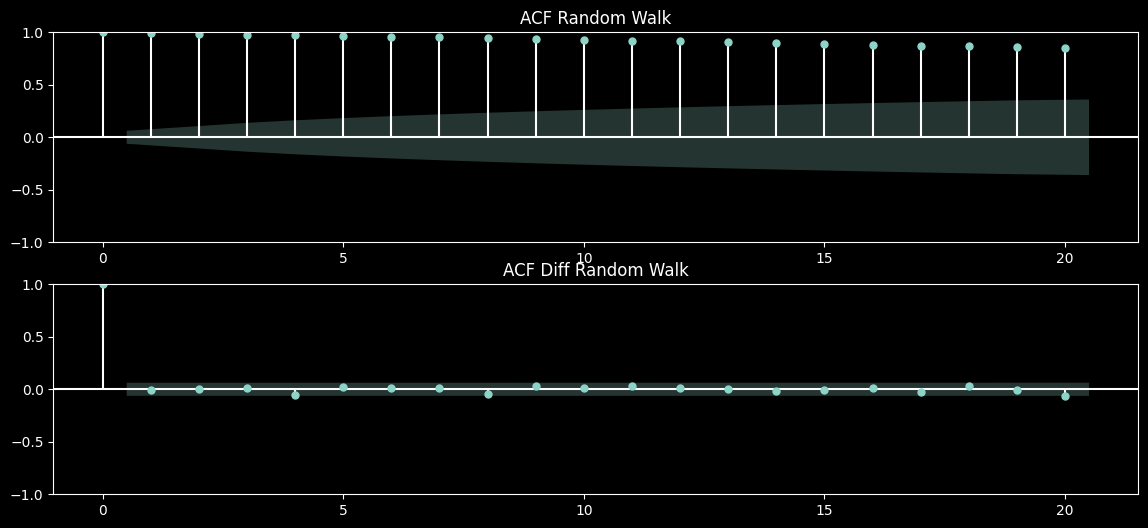

In [ ]:
fig, ax = plt.subplots(2, 1, figsize=(14, 6))

plot_acf(random_walk, lags=20, ax=ax[0])
ax[0].set_title('ACF Random Walk')

plot_acf(diff_random_walk, lags=20, ax=ax[1])
ax[1].set_title('ACF Diff Random Walk')

An ACF plot of our differenced random walk. Notice how there are no significant coefficients after lag 0. This is **a clear indicator that we are dealing with a random walk**.

In [ ]:
ADF_r_w = adfuller(random_walk)
ADF_diff_r_w = adfuller(diff_random_walk)

print(f'{WHITE}Random Walk ADF Statistic: {RED}{ADF_r_w[0]} {WHITE}Not very negatively large')
print(f'{WHITE}Random Walk p-value: {RED}{ADF_r_w[1]} {WHITE}> 0.05')

print(f'{WHITE}Diff Random Walk ADF Statistic: {GREEN}{ADF_diff_r_w[0]} {WHITE}Very negatively large {YELLOW}-> REJECT NULL HYPOTHESIS')
print(f'{WHITE}Diff Random Walk p-value: {GREEN}{ADF_diff_r_w[1]} {WHITE}< 0.05 {YELLOW}-> REJECT NULL HYPOTHESIS')

Random Walk ADF Statistic: -0.965952487691875 Not very negatively large
Random Walk p-value: 0.7654789696692581 > 0.05
Diff Random Walk ADF Statistic: -31.789310857560594 Very negatively large -> REJECT NULL HYPOTHESIS
Diff Random Walk p-value: 0.0 < 0.05 -> REJECT NULL HYPOTHESIS


### Is GOOGL a random walk?

In [ ]:
# Mount the Google Drive
# Allow access - check steps and methods in: https://neptune.ai/blog/google-colab-dealing-with-files
from google.colab import drive
drive.mount('/content/drive', force_remount=True)  # if Colab root directory is shown, go to /content folder

Mounted at /content/drive


In [ ]:
import os

# Check current working directory corresponds to Google Drive
retval = os.getcwd()
print(f"Current working directory {retval}")

# Change the directory - Google Drive -> folder from project "MODIS_Mexico_ThirdOrderPP"
path = "/content/drive/MyDrive/Colab_ML/datasets/"
os.chdir(path)

# Check current working directory corresponds to Google Drive
retval = os.getcwd()
print(f"Current working directory {retval}")

Current working directory /content
Current working directory /content/drive/MyDrive/Colab_ML/datasets


In [ ]:
import pandas as pd

In [ ]:
df = pd.read_csv('GOOGL.csv')

In [ ]:
df.head(10)

,Date,Open,High,Low,Close,Adj Close,Volume
0,2020-04-27,64.599998,64.705002,63.252998,63.542999,63.542999,44186000
1,2020-04-28,64.160004,64.237999,61.519001,61.629501,61.629501,80700000
2,2020-04-29,67.250000,68.007500,66.336502,67.109001,67.109001,108358000
3,2020-04-30,66.568001,67.500000,66.074997,67.334999,67.334999,55842000
4,2020-05-01,66.204498,67.571503,65.483002,65.865997,65.865997,48872000
5,2020-05-04,65.406502,66.223503,64.800499,66.144997,66.144997,30806000
6,2020-05-05,66.875000,68.550499,66.751503,67.450996,67.450996,39666000
7,2020-05-06,67.900002,68.434502,67.256500,67.271500,67.271500,31732000
8,2020-05-07,68.065498,68.800003,67.626999,68.463997,68.463997,30652000
9,2020-05-08,69.091003,69.832001,68.600502,69.217003,69.217003,33326000


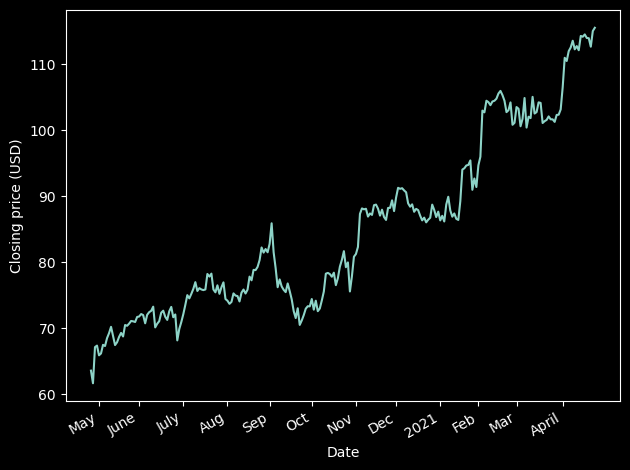

In [ ]:
fig, ax = plt.subplots()

ax.plot(df['Date'], df['Close'])
ax.set_xlabel('Date')
ax.set_ylabel('Closing price (USD)')
ax.set_title('Google stock price')

plt.xticks(
    [4, 24, 46, 68, 89, 110, 132, 152, 174, 193, 212, 235],
    ['May', 'June', 'July', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec', 2021, 'Feb', 'Mar', 'April']
)
fig.autofmt_xdate()
plt.tight_layout()

In [ ]:
GOOGL_ADF_result = adfuller(df['Close'])

print(f'{WHITE}ADF Statistic: {RED}{GOOGL_ADF_result[0]}')
print(f'{WHITE}p-value: {RED}{GOOGL_ADF_result[1]}')

ADF Statistic: 0.3183776061554642
p-value: 0.9781721063148977


In [ ]:
diff_close = np.diff(df['Close'], n=1)

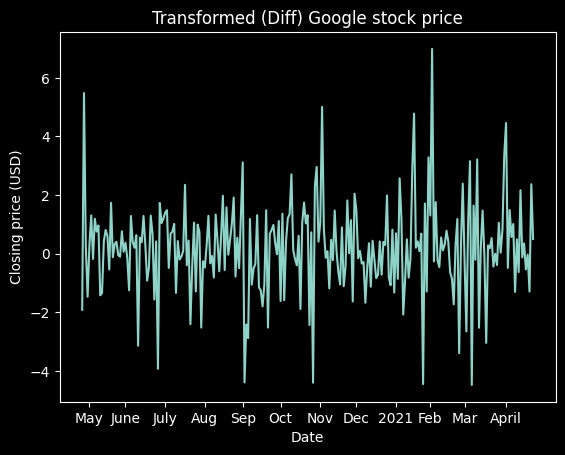

In [ ]:
fig, ax = plt.subplots()

ax.plot(diff_close);
ax.set_xlabel('Date')
ax.set_ylabel('Closing price (USD)')
ax.set_title('Transformed (Diff) Google stock price')

plt.xticks(
    [4, 24, 46, 68, 89, 110, 132, 152, 174, 193, 212, 235],
    ['May', 'June', 'July', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec', 2021, 'Feb', 'Mar', 'April']
);

In [ ]:
GOOGL_diff_ADF_result = adfuller(diff_close)

print(f'{WHITE}GOOGL Diff ADF Statistic: {GREEN}{GOOGL_diff_ADF_result[0]}')
print(f'{WHITE}GOOGL Diff p-value: {GREEN}{GOOGL_diff_ADF_result[1]}')

GOOGL Diff ADF Statistic: -5.263208852421109
GOOGL Diff p-value: 6.522974284131664e-06


Text(0.5, 1.0, 'Random Walk')

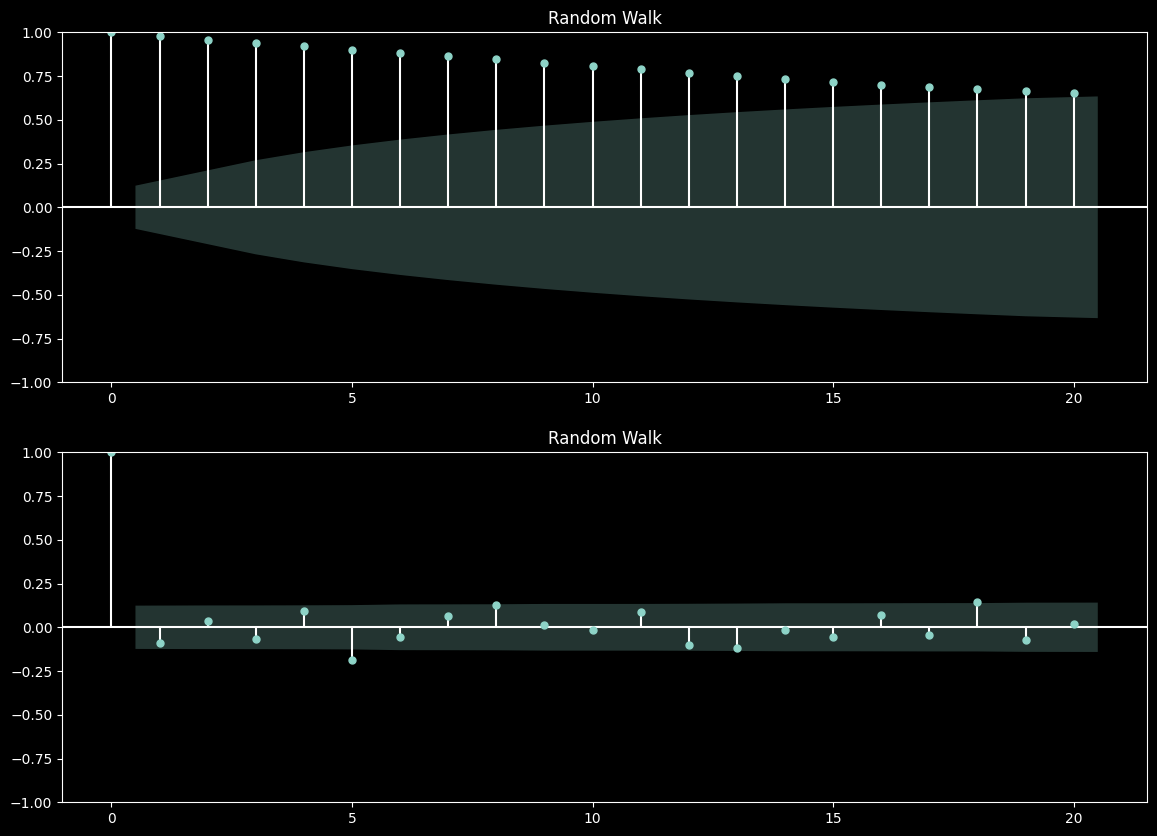

In [ ]:
fig, ax = plt.subplots(2, 1, figsize=(14, 10))

plot_acf(df['Close'], lags=20, ax=ax[0]);
ax[0].set_title('Random Walk')

plot_acf(diff_close, lags=20, ax=ax[1]);
ax[1].set_title('Random Walk')